<div style='text-align:center; font-weight:bold; font-size:38px'> Influence of Education Parameter on Country's GDP </div><br>

<div style='text-align:center; font-size:24px'> Hazim Fitri Bin Ahmad Faudzi (P152419) </div><br>

<div style='text-align:center'> Data Management (STQD6324) </div>

<h1 style='font-weight:bold'> 1. Introduction </h1>

<div style='text-align:justify'> This project investigates how some education parameters will effect a country's GDP. This investigation utilize multiple datasets that is publicly available from the worldbank data website https://data.wordbank.org </div>

<h2 style='font-weight:bold'> 1.1 Objectives </h2>

1. To analyze the impact of education parameters on a country's GDP.
2. To identify the relationship between education parameters and GDP.
3. To investigate the trend across income levels and regions towards GDP.

<h1 style='font-weight:bold'> 2. Data Collection </h1>

Datasets obtained from worldbank dataset website includes:
1. GDP per capita (current US$)
2. Government Education Expenditure (% of GDP)
3. Literacy Rate, Adult Total (% of people ages 15 and above)
4. Pupil-Teacher Ratio, Primary
5. School Enrollment, Primary (% gross)
6. School Enrollment, Secondary (% gross)

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyhive import hive
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# establish a connection to Hive
conn = hive.Connection(
    host='localhost',
    port=10000,
    username='maria_dev'
)

cursor = conn.cursor()

def hive_query(query):
    cursor.execute(query)
    for result in cursor.fetchall():
        print(result)

In [ ]:
# fetching raw data saved in GitHub downloaded from worlbank and remove the first 4 unnecessary rows
gdp = pd.read_csv('https://tinyurl.com/3zhv6cz2', skiprows=4)
edu_exp = pd.read_csv('https://tinyurl.com/bdzmkw8n', skiprows=4)
ptr = pd.read_csv('https://tinyurl.com/36bbjyes', skiprows=4)
pr_enrollment = pd.read_csv('https://tinyurl.com/mr37hpmk', skiprows=4)
sc_enrollment = pd.read_csv('https://tinyurl.com/4kbdw3kb', skiprows=4)
literacy = pd.read_csv('https://tinyurl.com/492krh5h', skiprows=4)

# save the data into csv with suitable format to upload to Hive ('|' as separator to avoid issues with commas in data, remove headers)
gdp.to_csv('data/worldbank/gdp.csv', index=False, header=False, sep='|')
edu_exp.to_csv('data/worldbank/education_expenditure.csv', index=False, header=False, sep='|')
ptr.to_csv('data/worldbank/pupil_teacher_ratio.csv', index=False, header=False, sep='|')
pr_enrollment.to_csv('data/worldbank/primary_enrollment.csv', index=False, header=False, sep='|')
sc_enrollment.to_csv('data/worldbank/secondary_enrollment.csv', index=False, header=False, sep='|')
literacy.to_csv('data/worldbank/literacy_rate.csv', index=False, header=False, sep='|')

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,97.989998,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,71.105171,71.029984,71.495399,72.658661,72.855759,72.638908,72.981560,73.275108,NaN,NaN
2,Afghanistan,AFG,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,55.465778,56.472198,59.747349,59.553669,59.703239,60.007320,60.290852,60.505550,NaN,NaN
4,Angola,AGO,"Literacy rate, adult total (% of people ages 1...",SE.ADT.LITR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,72.400002,NaN,NaN,NaN


In [ ]:
# fetching data (country name, country code, region, and income level) from worldbank API
url = "http://api.worldbank.org/v2/country?format=json&per_page=300"
data = requests.get(url).json()[1]

df = pd.DataFrame([
    {
        'Country': item['name'],
        'ID': item['id'],
        'Region': item['region']['value'],
        'Income Level': item['incomeLevel']['value']
    }
    for item in data
    if item['region']['value'] != 'Aggregates'  # Skip non-countries
])

df.to_csv('data/worldbank/worldbank_countries.csv', index=False, header=False, sep='|')

In [17]:
# Create table for country GDP data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.gdp (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/gdp'
""")

In [18]:
# create table for education expenditure data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.gov_edu_exp (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/gov_edu_exp'
""")

In [19]:
# create table for literacy rate data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.literacy_rate (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/literacy_rate'
""")

In [20]:
# create table for pupil-teacher ratio data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.pupil_teacher_ratio (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/pupil_teacher_ratio'
""")

In [ ]:
# create table for primary school enrollment data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.primary_enrollment (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/primary_enrollment'
""")

In [ ]:
# create table for secondary school enrollment data in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.secondary_enrollment (
    country_name STRING,
    country_code STRING,
    indicator_name STRING,
    indicator_code STRING,
    `1960` FLOAT, `1961` FLOAT, `1962` FLOAT, `1963` FLOAT, `1964` FLOAT, `1965` FLOAT, `1966` FLOAT, `1967` FLOAT, `1968` FLOAT, `1969` FLOAT,
    `1970` FLOAT, `1971` FLOAT, `1972` FLOAT, `1973` FLOAT, `1974` FLOAT, `1975` FLOAT, `1976` FLOAT, `1977` FLOAT, `1978` FLOAT, `1979` FLOAT, 
    `1980` FLOAT, `1981` FLOAT, `1982` FLOAT, `1983` FLOAT, `1984` FLOAT, `1985` FLOAT, `1986` FLOAT, `1987` FLOAT, `1988` FLOAT, `1989` FLOAT,
    `1990` FLOAT, `1991` FLOAT, `1992` FLOAT, `1993` FLOAT, `1994` FLOAT, `1995` FLOAT, `1996` FLOAT, `1997` FLOAT, `1998` FLOAT, `1999` FLOAT,
    `2000` FLOAT, `2001` FLOAT, `2002` FLOAT, `2003` FLOAT, `2004` FLOAT, `2005` FLOAT, `2006` FLOAT, `2007` FLOAT, `2008` FLOAT, `2009` FLOAT,
    `2010` FLOAT, `2011` FLOAT, `2012` FLOAT, `2013` FLOAT, `2014` FLOAT, `2015` FLOAT, `2016` FLOAT, `2017` FLOAT, `2018` FLOAT, `2019` FLOAT,
    `2020` FLOAT, `2021` FLOAT, `2022` FLOAT, `2023` FLOAT, `2024` FLOAT
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/secondary_enrollment'
""")

In [25]:
# create table for country metadata in Hive
cursor.execute("""
CREATE EXTERNAL TABLE IF NOT EXISTS worldbank.countries (
    country_name STRING,
    country_code STRING,
    region STRING,
    income_level STRING
)
ROW FORMAT DELIMITED
FIELDS TERMINATED BY '|'
STORED AS TEXTFILE
LOCATION '/user/maria_dev/worldbank/countries'
""")

In [37]:
# extracting only desired column from data in Hive
query = """
SELECT c.country_name AS country_name,
       c.country_code AS country_code,
       c.region AS region,
       c.income_level AS income_level,
       g.`2015` AS gdp,
       e.`2015` AS edu_exp,
       l.`2015` AS literacy_rate,
       p.`2015` AS pupil_teacher_ratio,
       pr.`2015` AS primary_enrollment,
       sc.`2015` AS secondary_enrollment
FROM worldbank.countries c
LEFT JOIN worldbank.gdp g 
ON c.country_code = g.country_code
LEFT JOIN worldbank.gov_edu_exp e
ON c.country_code = e.country_code
LEFT JOIN worldbank.literacy_rate l
ON c.country_code = l.country_code
LEFT JOIN worldbank.pupil_teacher_ratio p
ON c.country_code = p.country_code 
LEFT JOIN worldbank.primary_enrollment pr
ON c.country_code = pr.country_code
LEFT JOIN worldbank.secondary_enrollment sc
ON c.country_code = sc.country_code
"""

# read the data queried from Hive into a data frame in Python
df = pd.read_sql(query, conn)

# save the data into csv file to upload into Hive
df.to_csv('data/worldbank/data.csv')

df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_28016\550228556.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,country_name,country_code,region,income_level,gdp,edu_exp,literacy_rate,pupil_teacher_ratio,primary_enrollment,secondary_enrollment
0,Aruba,ABW,Latin America & Caribbean,High income,27458.2250,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,565.5697,3.25580,33.75384,43.38836,106.18242,53.28514
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,3213.9026,3.10000,66.23586,50.02951,119.14226,NaN
3,Albania,ALB,Europe & Central Asia,Upper middle income,3952.8035,3.43797,NaN,18.61557,105.68865,102.44073
4,Andorra,AND,Europe & Central Asia,High income,38654.9340,3.28035,NaN,9.93795,88.95535,92.54580


<h1 style='font-weight:bold'> 3. Data Cleaning </h1>

<h2 style='font-weight:bold'> 3.1 Handling missing data </h2> 

In [29]:
# inspect null values in the data
df.isnull().sum()

country_name              0
country_code              0
region                    0
income_level              0
gdp                       6
edu_exp                  51
literacy_rate           172
pupil_teacher_ratio      75
primary_enrollment       40
secondary_enrollment     63
dtype: int64

<div style='text-align:justify'> In the initial examination of the dataset, missing values were identified in several key variables, including GDP, government education expenditure, literacy rate, pupil teacher ratio, primary school enrollment, and secondary school enrollment. As GDP serves as the response variable for this study, any observations with missing GDP values were removed. This decision affected only six records, which is a minimal loss and unlikely to impact the overall integrity of the analysis. </div> <br>

<div style='text-align:justify'> The literacy rate variable exhibited a substantial proportion of missing data, with 172 out of 217 entries absent. This accounts for approximately 79 percent of the total observations. Given the extent of missingness, this variable was excluded from the analysis, as imputation would introduce considerable bias and compromise the reliability of the findings. </div> <br>

<div style='text-align:justify'> For the remaining variables with missing data, namely government education expenditure, pupil teacher ratio, and enrollment rates, missing values were imputed using the median. This approach was chosen to mitigate the influence of outliers while preserving as much data as possible. Removing these entries entirely would have drastically reduced the dataset size, limiting the robustness and generalizability of the subsequent analysis. The chosen data treatment strategy ensures a balance between data integrity and sample size sufficiency, thereby supporting meaningful statistical insights.</div> <br>

In [30]:
# drop rows where GDP is missing
df_drop_missing_gdp = df[df['gdp'].notnull()]

# drop literacy rate due to too many missing values
df_clean2 = df_drop_missing_gdp.drop(columns=['literacy_rate'])

# re-inspect null values in the cleaned data
df_clean2.isnull().sum()

country_name             0
country_code             0
region                   0
income_level             0
gdp                      0
edu_exp                 46
pupil_teacher_ratio     72
primary_enrollment      37
secondary_enrollment    61
dtype: int64

In [31]:
# copy currently cleaned data to a new DataFrame
df_clean3 = df_clean2.copy()

# define all nummeric columns
numeric_cols = df_clean3.select_dtypes(include='float64').columns.tolist()

# fill missing values in numeric columns with the median of each column grouped by region
for col in numeric_cols:
    df_clean3[col] = df_clean3.groupby('region')[col].transform(lambda x: x.fillna(x.median()))

# re-inspect null values in the final cleaned data
df_clean3.isnull().sum()

# copy the final cleaned data to a new DataFrame for further analysis (rename purpose)
cleaned_df = df_clean3.copy()

<h2 style='font-weight:bold'> 3.2 Handling Duplicate Rows </h2>

In [32]:
# check for duplicated data
cleaned_df.duplicated().sum()

0

Here we can see that there are no duplicated rows in the data.

<h2 style='font-weight:bold'> 3.3 Handling Outliers </h2>

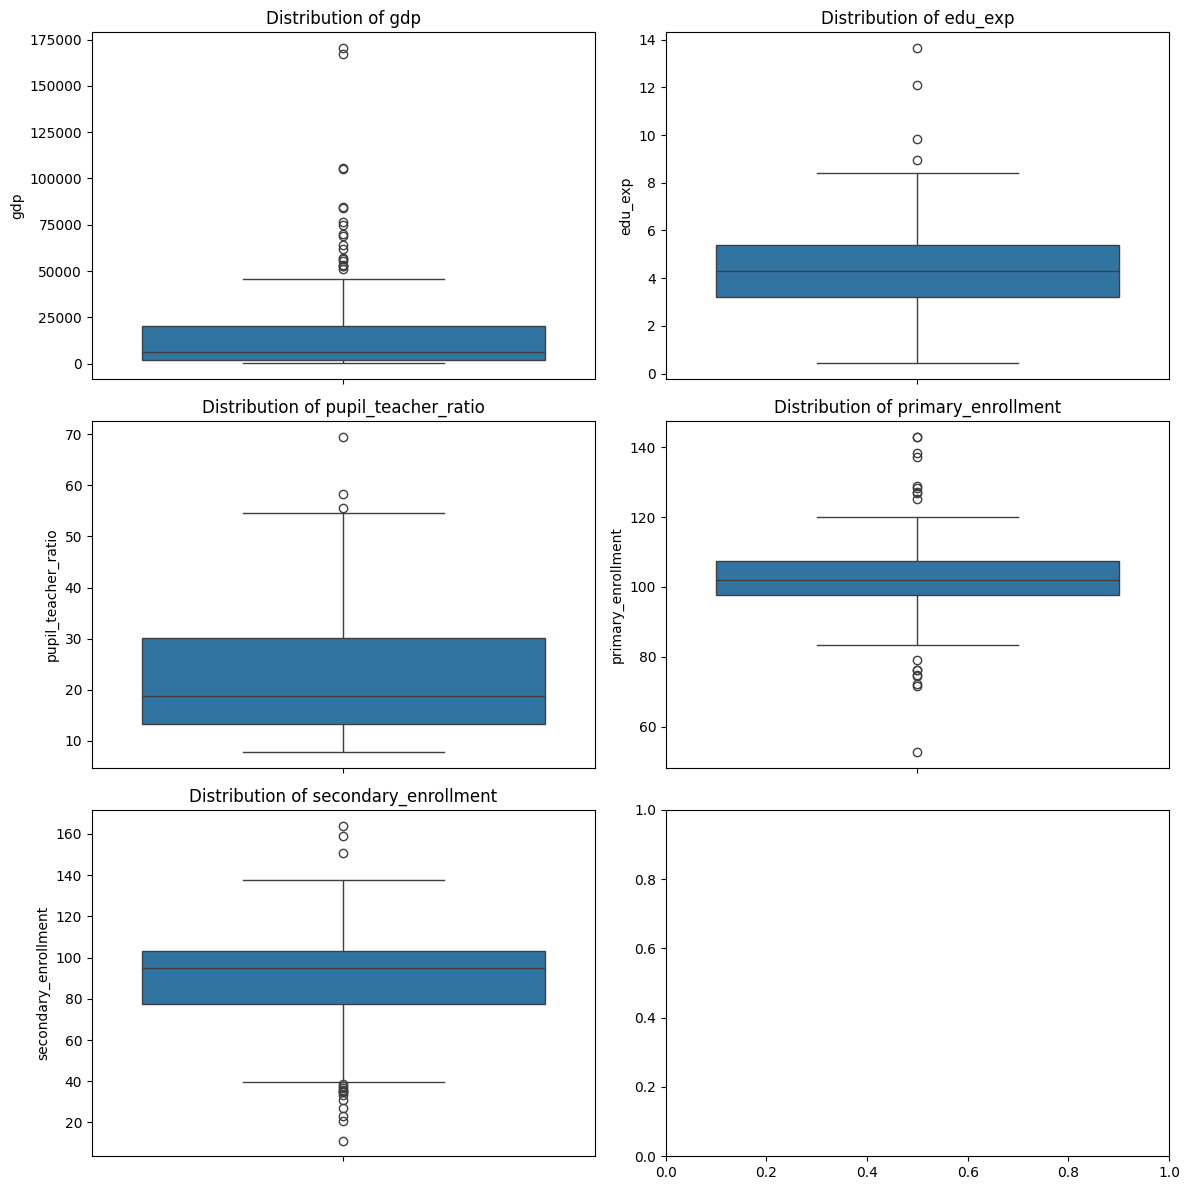

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(12,12)) # Create a 3x2 grid of subplots
axes = axes.flatten()

for i, col in enumerate(numeric_cols): # Iterate through the list of columns
    sns.boxplot(y=df[col], ax=axes[i]) # Create boxplot of each column
    axes[i].set_title(f'Distribution of {col}') # Set title of each subplot

plt.tight_layout()
plt.show() # display plot

The boxplots show that there are outliers in all 5 numerical column of this dataset. These outliers should be examined further as they might effect statistical modeling or signal important socio-economic differences.

<h1 style='font-weight:bold'> 4. Exploratory Data Analysis </h1>

<h2 style='font-weight:bold'> 4.1 Summary Statistics </h2>

In [51]:
# view the statistical summary for both categorical variables
cleaned_df.describe(include='object')

,country_name,country_code,region,income_level
count,211,211,211,211
unique,211,211,7,4
top,Aruba,ABW,Europe & Central Asia,High income
freq,1,1,57,82


<div style='text-align:justify'> The statistical summary of categorical variables shows that a total of 211 observations are recorded across four categorical features. Both country name and country code exhibit 211 unique entries, confirming that each country is uniquely represented in the dataset without duplication. Next, the region variable indicates that there are 7 distinct regions with Europe & Central Asis emerged as the region with highest number of countries appearing 57 times in the data. Similarly, income level variable consists of 4 distinct categories with High income emerged as the most income level accounting for 82 countries. </div>

In [49]:
# view the statistical summary for both numerical variables
cleaned_df.describe(include='float64')

,gdp,edu_exp,pupil_teacher_ratio,primary_enrollment,secondary_enrollment
count,211.000000,211.000000,211.000000,211.000000,211.000000
mean,17046.169039,4.449362,21.794284,102.718159,85.921168
std,25262.774748,1.643213,11.449027,10.891014,27.164391
min,280.966830,0.436955,7.845240,52.786980,11.230950
25%,2196.108000,3.441233,13.246210,98.612180,74.003088
50%,6154.496000,4.242013,16.997470,102.214330,93.968200
75%,20513.037500,4.982337,27.254865,106.085625,102.279175
max,170437.100000,13.647000,69.509690,142.991030,164.079820


<div style='text-align:justify'> The statistical summary generated from the numcerical variables gives a detailed overview of the central tendencies and dispersion present in the dataset. For GDP, the mean is 17,046 with a standard deviation of 25,263 indicating high variability across countries. The GDP has range from as low as 281 to a maximum of 280,437, reflecting the wide economic disparity among nations. The interquartile range of 2,194 to 20,513 hightlights that most countries has moderate economic output while a few countries with high GDP act as outliers. </div><br>

<div style='text-align:justify'> The average education expenditure is 4.45% of the GDP of a country with relatively low variance of 1.64%. The values are mostly between 3.44% and 4.98% indicating that most countries allocate a modest yet consistent share of their economic resources to education. </div><br>

<div style='text-align:justify'> The pupil-teacher ratio has a mean of 21.79 suggesting that on average, there are approximately 22 students per techer. However, the high standard deviation of 11.45 and range of 7.85 to 69.51 indicate a significant variation in techer availability across countries. </div><br>

<div style='text-align:justify'> For enrollment rates, primary school enrollment is relatively high and consistent with a mean of 104.72%. In contrast, the secondary school enrollment has a lower mean of 85% and wider spread of 11% to 164%. This shows that there are disparities in access to post-primary education. </div>

<h2 style='font-weight:bold'> 4.2 Relationship Between GDP and Education Metrics </h2>

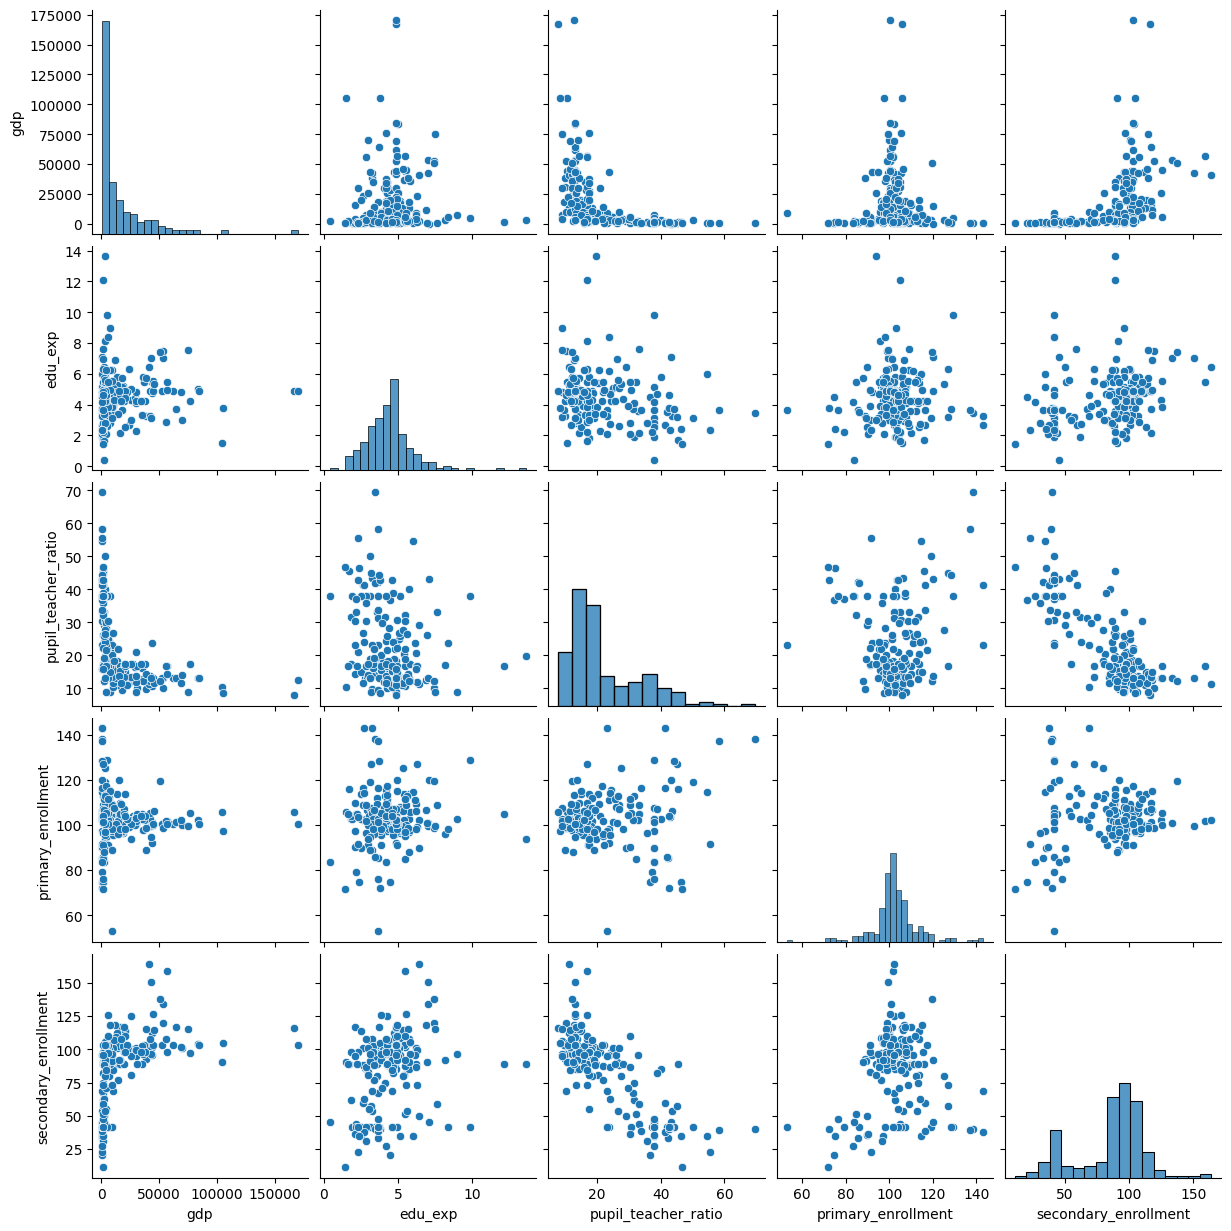

In [35]:
# plot a pairplot to visualize relationships between numeric variables
sns.pairplot(cleaned_df[numeric_cols]);

<div style='text-align:justify'> A pairplot was utilized to explore the relationships among key numeric indicators which are GDP, education expenditure, pupil-teacher ratio, primary school enrollment, and secondary school enrollment. This visualization provides an initial exploratory view to identify patterns and dependencies relevant to national economic and educational performance. </div><br>

<div style='text-align:justify'> The analysis reveals a positive association between GDP and secondary school enrollment. Countries with greater participation in secondary education tend to report higher GDP levels. This finding is consistent with previous research suggesting that human capital accumulation, particularly through secondary education, contributes significantly to economic productivity and growth (Barro, 2001; Hanushek & Woessmann, 2008). A notable negative correlation is also observed between GDP and pupil-teacher ratio, indicating that wealthier countries often maintain lower class sizes, supporting better educational outcomes (UNESCO, 2014). Moreover, GDP and education expenditure show a mild positive trend, reinforcing the notion that high-income countries allocate a larger proportion of resources toward education (World Bank, 2018). </div><br>

<div style='text-align:justify'> The strong positive relationship between primary and secondary enrollment suggests a systemic alignment in educational continuity. This reflects the strength of national education systems where robust foundational access enables progression to higher educational levels (OECD, 2016). In contrast, education expenditure does not exhibit a strong linear relationship with either enrollment or pupil-teacher ratio. This discrepancy points to the influence of non-monetary factors such as policy effectiveness, governance, and social barriers, which can mediate the impact of spending on actual educational outcomes (UNESCO GEM Report, 2021). </div><br>

<div style='text-align:justify'> These insights underscore the importance of targeted investment in secondary education and teacher availability as levers for long-term economic advancement. Governments in developing regions should prioritize efficiency in fund allocation, accompanied by systemic reforms to ensure that education expenditure translates into tangible improvements in access and quality. </div>

<h2 style='font-weight:bold'> 4.3 GDP Distribution by Income Level </h2>

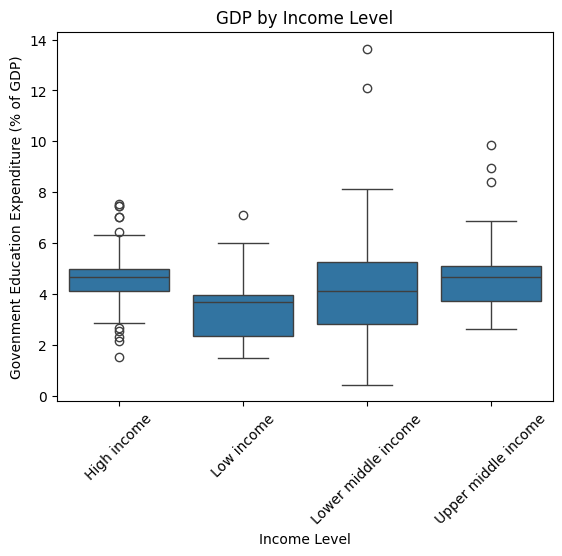

In [57]:
# plot a boxplot of GDP by income level
sns.boxplot(data=cleaned_df, x='income_level', y='edu_exp')
plt.title('GDP by Income Level')
plt.xticks(rotation=45)
plt.xlabel('Income Level')
plt.ylabel('Govenment Education Expenditure (% of GDP)');

<div style='text-align:justify'> The boxplot illustrates the distribution of government education expenditure as a percentage of GDP across countries of varying income levels: high income, upper middle income, lower middle income, and low income. From the visualization, it is evident that high-income countries tend to have a relatively narrow range of education spending, typically clustered between 4% and 6%. This consistency suggests stable fiscal policies and institutional capacity to maintain steady investment in education. In contrast, upper middle-income countries exhibit a slightly broader distribution, with several nations surpassing 8% of GDP, indicating strong national prioritization of education in some cases. </div> <br>

<div style='text-align:justify'> Lower middle-income countries display the widest variation in expenditure, ranging from under 1% to nearly 14% of GDP. This substantial spread reflects the diversity of fiscal strategies and resource availability within this group, where some nations aggressively invest in education despite economic limitations, while others may struggle to allocate sufficient funding. Low-income countries generally allocate a lower share of GDP to education, with a median value below 4%, although a few notable outliers invest significantly more, possibly through donor assistance or prioritization of education in national development agendas. </div><br>

<div style='text-align:justify'> Overall, the graph reveals that while high-income nations maintain stable and predictable education investment, lower-income groups show greater variability in spending patterns. This variation underscores differences in policy priorities, governance, and financial capacity. Importantly, the presence of outliers across all income levels suggests that economic status alone does not determine education investment; rather, national policy choices and external support play critical roles. These insights emphasize the need for not only sustained education financing but also efficient and equitable utilization of resources to foster long-term development and reduce global disparities in educational access and quality. </div>

<h2 style='font-weight:bold'> 4.4 Correlation Matrix of Economic and Education Indicators </h2>

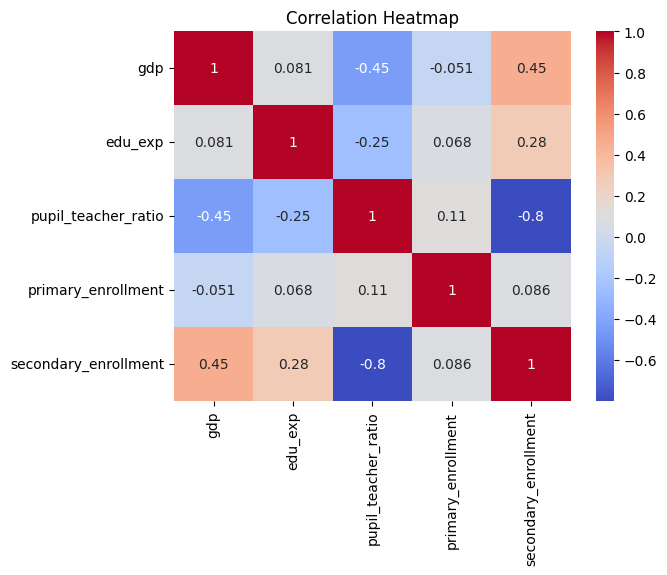

In [54]:
# plot a heatmap of correlations between numeric variables
sns.heatmap(cleaned_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show();


<div style='text-align:justify'> The correlation heatmap provides a visual representation of the linear relationships between the main numerical variables in the dataset, including GDP, education expenditure, pupil teacher ratio, primary enrollment, and secondary enrollment. Each cell in the heatmap shows a correlation coefficient ranging from negative one to positive one, indicating the strength and direction of the relationship between two variables. </div> <br>

<div style='text-align:justify'> One of the most prominent observations is the positive correlation between GDP and secondary enrollment, with a coefficient of zero point four five. This suggests that countries with higher levels of secondary education participation tend to experience higher economic output. Similarly, secondary enrollment is positively correlated with education expenditure, indicating that increased investment in education often coincides with broader access to secondary schooling. </div> <br>

<div style='text-align:justify'> Conversely, the pupil teacher ratio is negatively correlated with both GDP and secondary enrollment. The negative correlation of minus zero point four five with GDP and minus zero point eight with secondary enrollment implies that countries with fewer students per teacher are more likely to be economically developed and have higher levels of secondary school participation. This supports the idea that lower class sizes contribute to better educational outcomes, which in turn enhance economic productivity. </div> <br>

<div style='text-align:justify'> The correlation between primary enrollment and other variables appears weak, suggesting that primary education is more uniformly distributed across countries and may not be a strong differentiator in explaining variations in economic performance. Lastly, the modest positive correlation between GDP and education expenditure indicates that wealthier nations are slightly more likely to allocate a higher share of resources toward education, although this relationship is not particularly strong. </div> <br>

<h2 style='font-weight:bold'> 4.5 GDP Variation Across Pupil-Teacher Ratio Levels </h2>

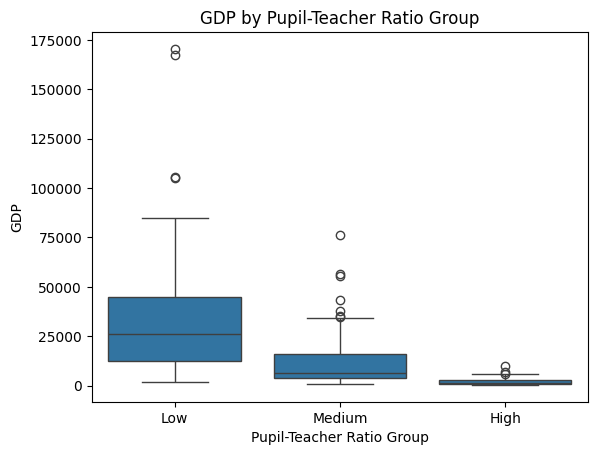

In [44]:
# plot a boxplot of GDP by level of pupil-teacher ratio
cleaned_df['ptr_group'] = pd.cut(cleaned_df['pupil_teacher_ratio'], bins=[0,15,25,40], labels=['Low','Medium','High'])
sns.boxplot(data=cleaned_df, x='ptr_group', y='gdp')
plt.title('GDP by Pupil-Teacher Ratio Group')
plt.xlabel('Pupil-Teacher Ratio Group')
plt.ylabel('GDP');

<div style='text-align:justify'> The boxplot presents the distribution of GDP among countries grouped by pupil teacher ratio, categorized as low, medium, and high. The visual clearly indicates a negative relationship between pupil teacher ratio and national income levels. Countries in the low pupil teacher ratio group, which indicates better teacher availability per student, show the highest median GDP along with a wide interquartile range. This group also contains several extreme outliers, representing nations with exceptionally high economic output. These characteristics suggest that countries with more favorable educational staffing conditions tend to have stronger economic performance. </div> <br>

<div style='text-align:justify'> In comparison, countries in the medium and high pupil teacher ratio groups demonstrate noticeably lower GDP values. The medium group displays a moderate GDP level with some variability, while the high ratio group shows the lowest median GDP and a narrow distribution. This pattern implies that limited teacher availability is often associated with constrained economic outcomes. </div> <br>

<div style='text-align:justify'> Overall, the figure supports the idea that countries with better teacher to student ratios experience greater economic benefits. This observation reinforces the broader understanding that investments in educational quality, particularly through the hiring and retention of sufficient teaching staff, can significantly contribute to economic development. The results reflect the importance of human capital in national progress, where educational infrastructure plays a central role in shaping future productivity and income growth. </div> <br>

<h2 style='font-weight:bold'> 4.6 Top 10 Country with Highest GDP: Economic Powerhouses </h2>

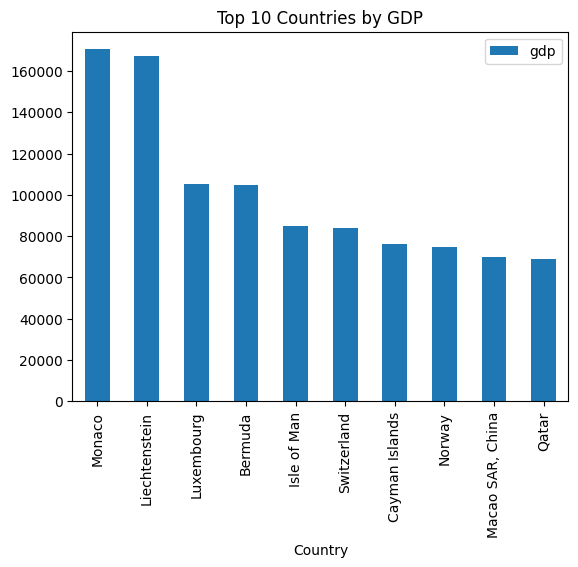

In [45]:
# plot a barplot of the top 10 countries by GDP
top10 = cleaned_df.sort_values('gdp', ascending=False).head(10)
top10.plot(kind='bar', x='country_name', y=['gdp'])
plt.title('Top 10 Countries by GDP')
plt.xlabel('Country');

<div style='text-align:justify'> The bar chart displays the top ten countries by gross domestic product, revealing a significant concentration of economic power among a small group of nations. Monaco and Liechtenstein occupy the top positions, each reporting GDP values exceeding 160 thousand. These countries are known for their small populations and highly developed service sectors, particularly in finance, tourism, and real estate. Their economic models rely on attracting foreign capital and offering favorable regulatory environments, which result in extremely high GDP per capita values. </div> <br>

<div style='text-align:justify'> Other countries in the list such as Luxembourg, Bermuda, and the Isle of Man also reflect similar characteristics. These are either financial centers or tax-friendly jurisdictions with specialized economies. Their inclusion in the top ten indicates that national wealth can be significantly influenced by focused economic strategies and strong global financial integration rather than by sheer population size or land area. </div><br>

<div style='text-align:justify'> Switzerland and Norway also feature prominently, representing stable, high-income economies with diverse industrial and resource-based sectors. Both countries benefit from strong institutions, high productivity, and long term investment in human capital. The presence of Macao and Qatar further highlights the role of tourism and natural resources, respectively, in driving national income. Macao has built a strong economy around entertainment and hospitality, while Qatar’s wealth is derived largely from oil and gas exports. </div><br>

<div style='text-align:justify'> Overall, the graph demonstrates that countries with small populations but highly efficient or strategically positioned economies can achieve exceptionally high GDP values. It also suggests that specialized sectors such as finance, energy, and tourism can generate substantial economic returns when supported by favorable policies and governance structures. This insight emphasizes the importance of strategic economic planning and international competitiveness in achieving national prosperity. </div><br>

<h2 style='font-weight:bold'> 4.7 Top 10 Countries with Highest Education Expenditure </h2>

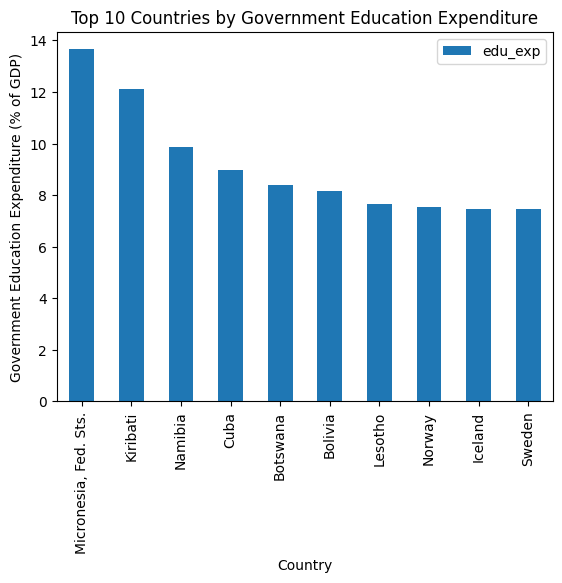

In [48]:
# plot a barplot of the top 10 countries by government education expenditure
top10 = cleaned_df.sort_values('edu_exp', ascending=False).head(10)
top10.plot(kind='bar', x='country_name', y=['edu_exp'])
plt.title('Top 10 Countries by Government Education Expenditure')
plt.xlabel('Country')
plt.ylabel('Government Education Expenditure (% of GDP)');

<div style='text-align:justify'> The bar chart highlights the top ten countries in terms of government education expenditure as a percentage of GDP. The leading country on this list is the Federated States of Micronesia, where education spending reaches nearly fourteen percent of the national GDP. This is followed closely by Kiribati and Namibia, which also allocate a significant portion of their resources to the education sector. These countries, though not among the highest in terms of absolute GDP, demonstrate a strong fiscal commitment to human capital development. </div> <br>

<div style='text-align:justify'> The chart reveals that several of the top spenders, such as Cuba, Botswana, and Bolivia, are classified as small or middle-income nations. Their prioritization of education suggests a developmental strategy aimed at long term social and economic advancement. These countries likely view education as a foundational investment that can support future gains in productivity, equity, and national resilience. </div><br>

<div style='text-align:justify'> The inclusion of high income nations such as Norway, Iceland, and Sweden indicates that strong education spending is not limited to developing economies. These countries are known for their comprehensive and inclusive education systems, often ranked among the best globally. Their presence in this chart reflects sustained public investment aimed at maintaining high quality standards and equal access to education. </div><br>

<div style='text-align:justify'> Overall, the graph demonstrates that high government education expenditure can be found across a range of income levels and regions. It suggests that the political will to prioritize education plays a crucial role in shaping national policy, regardless of a country's economic standing. This further implies that substantial investment in education is a shared characteristic of nations that value inclusive development and long term human capital formation. </div><br>

<h1 style='font-weight:bold'> 6. Recommendations </h1>

<div style='text-align:justify'>Based on the comprehensive analysis of the dataset exploring the relationship between educational indicators and economic development across countries, several key recommendations can be made to strengthen the outcomes and applications of this project: </div> <br>

<div style='text-align:justify'> First, countries with lower GDP and high pupil teacher ratios should prioritize investment in educational infrastructure, particularly through the recruitment and training of qualified teachers. Reducing class sizes can lead to improved learning outcomes and long term economic benefits, as shown by the consistent association between low pupil teacher ratios and higher GDP levels in the analysis. </div><br>

<div style='text-align:justify'> Second, greater attention should be given to improving secondary school enrollment. The findings suggest that secondary education is more closely linked with economic performance than primary education. Policy interventions that reduce financial, social, and geographic barriers to secondary education access are essential, especially in lower and lower middle income countries </div><br>

<div style='text-align:justify'> Third, governments must ensure that increases in education expenditure are accompanied by improvements in efficiency, governance, and accountability. While high spending is commendable, the analysis reveals that outcomes vary significantly, indicating that how funds are used is as important as how much is spent. </div><br>

<div style='text-align:justify'>Fourth, international collaboration should be encouraged among countries that have demonstrated effective education policies and outcomes. Countries with limited resources can benefit from knowledge exchange and policy transfer, particularly in teacher training, digital learning, and curriculum development.</div><br>

<div style='text-align:justify'> Lastly, further research is recommended using more granular or time series data to examine causality and track progress over time. Incorporating additional variables such as literacy rates, digital access, and labor market alignment can enrich the understanding of how education contributes to inclusive and sustainable economic growth. </div>

<h1 style='font-weight:bold'> 8. Conclusion </h1>

<div style='text-align:justify'>This study examined the relationship between educational indicators and economic performance across various countries, drawing on publicly available global datasets. Through rigorous data cleaning, exploratory data analysis, and statistical modeling, the project revealed several significant patterns linking education to national economic output. </div><br>

<div style='text-align:justify'>Key findings indicate that higher levels of secondary enrollment and lower pupil-teacher ratios are associated with increased GDP. Moreover, countries that allocate a larger proportion of their GDP to education tend to show stronger human capital development, although the efficiency of expenditure remains a crucial determinant of success.</div><br>

<div style='text-align:justify'>The analysis also highlighted the disparities in economic and educational conditions across income groups. High-income countries consistently outperform others in both educational access and GDP levels, while several low- and middle-income countries demonstrate commendable education spending despite economic limitations.</div><br>

<div style='text-align:justify'>Overall, the results emphasize the strategic role of education in shaping long-term economic outcomes. Policymakers are encouraged to invest in quality education systems, reduce structural barriers to learning, and ensure that fiscal efforts translate into effective educational delivery. These actions are vital for achieving equitable growth, improving workforce quality, and fostering national resilience in a rapidly evolving global economy.</div>



<h1 style='font-weight:bold'> 9. References </h1> <br>


1. Hanushek, E. A., & Woessmann, L. (2008). The role of cognitive skills in economic development. Journal of Economic Literature, 46(3), 607–668.

2. Hanushek, E. A., & Woessmann, L. (2010). The Economics of International Differences in Educational Achievement. NBER Working Paper No. 15949.

3. OECD. (2016). Education at a Glance 2016: OECD Indicators. OECD Publishing.

4. UNESCO. (2014). Teaching and Learning: Achieving Quality for All. EFA Global Monitoring Report.

5. UNESCO GEM Report. (2021). Non-state actors in education: Who chooses? Who loses?

6. World Bank. (2018). World Development Report: Learning to Realize Education’s Promise.

7. World Bank. (2023). World Development Indicators. https://databank.worldbank.org/source/world-development-indicators

8.  World Bank. (2018). World Development Report: Learning to Realize Education’s Promise.